# Load libraries and mount the drive

In [1]:
# Load all necessary libraries, numpy, pandas, keras, cobra 
import numpy as np
import pandas as pd

# Load duplicated-reactions model

In [2]:
import cobra
DIRECTORY = './'
cobraname = 'iML1515_duplicated'
cobrafile = DIRECTORY+'COBRA-dataset/'+cobraname+'.xml'
model = cobra.io.read_sbml_model(cobrafile)


In [3]:
for reac in model.reactions:
    if reac.id.startswith("EX_") and reac.upper_bound == 0:
        # reac.upper_bound = 1e-300 # corrects zero upper bound for the "EX" reaction to be displayed in model.medium
        pass

# Define the steady and variable elements of the medium, and functions

In [4]:
# Minimum medium always ON
minmed_1000 = ['EX_pi_e_i', 'EX_co2_e_i', 'EX_fe3_e_i', 'EX_h_e_i', 'EX_mn2_e_i', 
          'EX_fe2_e_i', 'EX_zn2_e_i', 'EX_mg2_e_i', 'EX_ca2_e_i', 'EX_ni2_e_i', 
          'EX_cu2_e_i', 'EX_sel_e_i', 'EX_cobalt2_e_i', 'EX_h2o_e_i', 'EX_mobd_e_i', 
          'EX_so4_e_i', 'EX_nh4_e_i', 'EX_k_e_i', 'EX_na1_e_i', 
          'EX_cl_e_i', 'EX_o2_e_i', 'EX_tungs_e_i', 'EX_slnt_e_i']

minmed_10 = ['EX_glyc_e_i', 'EX_arab__L_e_i']

minmed = minmed_1000

# Variable medium ON or OFF, when empty all medium reaction are taken 
varmed = ['EX_his__L_e_i',  'EX_leu__L_e_i', 'EX_phe__L_e_i', 'EX_lys__L_e_i', 
          'EX_tyr__L_e_i', 'EX_val__L_e_i', 'EX_asp__L_e_i', 'EX_met__L_e_i', 
          'EX_ile__L_e_i', 'EX_gln__L_e_i', 'EX_cys__L_e_i', 'EX_ser__L_e_i', 
          'EX_ala__L_e_i', 'EX_trp__L_e_i', 'EX_asn__L_e_i', 'EX_pro__L_e_i', 
          'EX_thr__L_e_i', 'EX_gly_e_i', 'EX_arg__L_e_i', 'EX_glu__L_e_i', 
          'EX_melib_e_i', 'EX_sucr_e_i', 'EX_tre_e_i', 'EX_lcts_e_i', 'EX_ac_e_i', 
          'EX_pyr_e_i', 'EX_cit_e_i']

varmed += minmed_10

# measure = ['BIOMASS_Ec_iML1515_core_75p37M', 'RP1_sink']
measure = ['BIOMASS_Ec_iML1515_core_75p37M']

def read_training_data(filename):
    filename += '.csv'
    dataframe = pd.read_csv(filename, header=0)
    dataset = dataframe.values
    DATA = np.asarray(dataset[:,:])
    return DATA

def set_med(model, IN, activated):
    # set the medium with IN dict (the variable of the function to optimize)
    # set the unactivated at zero (absent compounds in the meodum composition)
    medium = model.medium # This is the model medium  
    medini = medium.copy()
    for k in medium.keys(): # Reset the medium
        medium[k] = 1e-300
        if k in minmed_1000:
            medium[k] = 1000
    for k in IN.keys(): # Additional cmpds added to medium
        if k in medium.keys() and k in activated:
            medium[k] = IN[k]
        if k not in medium.keys() and k in activated:
            model.reactions.get_by_id(k).upper_bound = IN[k]
    model.medium = medium
    return model

# Get the binary vectors describing medium composition, and the corresponding experimental measures

In [5]:
xp_name = 'EXP_All'
xp_file = DIRECTORY+'COBRA-dataset/'+xp_name

xp_data = read_training_data(xp_file)

xp = []

for dat in xp_data:
    on = []
    for med in varmed:
        if dat[varmed.index(med)] == 1:
          # print(med)
          on.append(med)
        # print(on)
        biom = dat[-2]
        lyco = dat[-1]

    xp.append([on, biom, lyco])

# Define the function to optimize

### Bonus: Flux sampling example

In [50]:
# Cobra utilities and stoichiometric derived matrices
def get_index_from_id(name,L):
    # Return index in L of id name
    for i in range(len(L)):
        if L[i].id == name:
            return i
    return -1

def get_objective(model):
    # Get the reaction carring the objective
    # Someone please tell me if there is
    # a clearner way in Cobra to get
    # the objective reaction

    r = str(model.objective.expression)
    r = r.split()
    r = r[0].split('*')
    obj_id = r[1]

    # line below crash if does not exist
    r = model.reactions.get_by_id(obj_id)

    return obj_id


obj = get_objective(model)
obj_index = get_index_from_id(obj, model.reactions)

medium_vect = [10 for x in varmed]
medium_dict = {x:val for x, val in zip(varmed, medium_vect)}

# taking just the first exeperimental data
activated = xp[0][0]
biom = xp[0][1]

with model as model:

    # set upper bounds to 10 for all present compounds
    this_model = set_med(model, medium_dict, activated)

    # set biomass lower = upper = experimental value
    this_model.reactions.get_by_id(obj).upper_bound = biom
    this_model.reactions.get_by_id(obj).lower_bound = biom

    cobra.flux_analysis.parsimonious.add_pfba(this_model)
    print(this_model.objective)
    # if pfba here does not work, try that
    cobra.util.fix_objective_as_constraint(this_model)

    # https://github.com/opencobra/cobrapy/issues/786
    # some help here maybe

    # Sample flux distributions compliant with bounds on medium and GR
    # With pFBA objective, very long to run for iML1515
    # For 1 experimental setup, drawing 10 flux distributions
    print("sampling started")
    s = cobra.sampling.sample(this_model, 2000, method="optgp", thinning=200, processes=2000)
    # s = cobra.sampling.sample(this_model, 50, method="achr", thinning=10000)
    print("sampling over")

Minimize
1.0*12DGR120tipp + 1.0*12DGR120tipp_reverse_757ef + 1.0*12DGR140tipp + 1.0*12DGR140tipp_reverse_aea46 + 1.0*12DGR141tipp + 1.0*12DGR141tipp_reverse_a0957 + 1.0*12DGR160tipp + 1.0*12DGR160tipp_reverse_eac16 + 1.0*12DGR161tipp + 1.0*12DGR161tipp_reverse_dcd80 + 1.0*12DGR180tipp + 1.0*12DGR180tipp_reverse_7a012 + 1.0*12DGR181tipp + 1.0*12DGR181tipp_reverse_34fd5 + 1.0*12PPDRtex_i + 1.0*12PPDRtex_i_reverse_10087 + 1.0*12PPDRtex_o + 1.0*12PPDRtex_o_reverse_28272 + 1.0*12PPDRtpp_i + 1.0*12PPDRtpp_i_reverse_903d4 + 1.0*12PPDRtpp_o + 1.0*12PPDRtpp_o_reverse_0e6f0 + 1.0*12PPDStex_i + 1.0*12PPDStex_i_reverse_74e5b + 1.0*12PPDStex_o + 1.0*12PPDStex_o_reverse_4d7cb + 1.0*12PPDStpp_i + 1.0*12PPDStpp_i_reverse_03968 + 1.0*12PPDStpp_o + 1.0*12PPDStpp_o_reverse_5a5b5 + 1.0*13PPDH2_for + 1.0*13PPDH2_for_reverse_28987 + 1.0*13PPDH2_rev + 1.0*13PPDH2_rev_reverse_670f7 + 1.0*14GLUCANabcpp + 1.0*14GLUCANabcpp_reverse_c6351 + 1.0*14GLUCANtexi + 1.0*14GLUCANtexi_reverse_2d4f8 + 1.0*23CAMPtex_i + 1.0

ValueError: Cannot sample from an inhomogenous problem with only 2 search directions.

In [46]:
# showing the biomass of the sampled flux distributions (always reference value)
s[obj]

0     0.018899
1     0.018899
2     0.018899
3     0.018899
4     0.018899
5     0.018899
6     0.018899
7     0.018899
8     0.018899
9     0.018899
10    0.018899
11    0.018899
12    0.018899
13    0.018899
14    0.018899
15    0.018899
16    0.018899
17    0.018899
18    0.018899
19    0.018899
20    0.018899
21    0.018899
22    0.018899
23    0.018899
24    0.018899
25    0.018899
26    0.018899
27    0.018899
28    0.018899
29    0.018899
30    0.018899
31    0.018899
32    0.018899
33    0.018899
34    0.018899
35    0.018899
36    0.018899
37    0.018899
38    0.018899
39    0.018899
40    0.018899
41    0.018899
42    0.018899
43    0.018899
44    0.018899
45    0.018899
46    0.018899
47    0.018899
48    0.018899
49    0.018899
Name: BIOMASS_Ec_iML1515_core_75p37M, dtype: float64

In [47]:
# showing the exchange reactions of the sampled flux distributions (always reference value)
inflow_exchanges = activated
outflow_exchanges = [activ[:-1] for activ in activated]
outflow_exchanges = [outf+'o' for outf in outflow_exchanges]

s[inflow_exchanges + outflow_exchanges]

,EX_gln__L_e_i,EX_pro__L_e_i,EX_thr__L_e_i,EX_arg__L_e_i,EX_lcts_e_i,EX_glyc_e_i,EX_arab__L_e_i,EX_gln__L_e_o,EX_pro__L_e_o,EX_thr__L_e_o,EX_arg__L_e_o,EX_lcts_e_o,EX_glyc_e_o,EX_arab__L_e_o
0,9.980333,9.897235,9.888372,9.805996,9.939353,9.848571,9.922030,0.206724,0.045170,0.107429,0.521418,0.236837,0.011561,0.185889
1,9.954354,9.903111,9.890165,9.807950,9.925618,9.978388,9.905014,0.254805,0.008435,0.096622,0.565353,0.112366,0.115481,0.146183
2,9.965575,9.930873,9.921816,9.756076,9.843734,9.997011,9.706297,0.078022,0.421989,0.002941,0.592002,0.004063,0.184432,0.234323
3,9.962738,9.872103,9.856999,9.745088,9.947477,9.972024,9.751469,0.123469,0.153335,0.020983,0.075431,0.053068,0.019927,0.115344
4,9.809132,9.828167,9.871657,9.795141,9.816067,9.986406,9.846874,0.018035,0.088547,0.079087,0.117919,0.172136,0.001603,0.222755
5,9.973659,9.860588,9.943206,9.865970,9.956553,9.907160,9.857701,0.104261,0.160111,0.180159,0.060686,0.009748,0.114965,0.117806
6,9.860015,9.813252,9.981915,9.938243,9.972237,9.983912,9.886542,0.290204,0.358486,0.245427,0.374048,0.085520,0.036029,0.189299
7,9.839947,9.823587,9.993977,9.989812,9.952847,9.909596,9.996069,0.061625,0.449468,0.007841,0.104166,0.081410,0.071326,0.012408
8,9.659796,9.720401,9.991118,9.913723,9.888901,9.908660,9.887757,0.075905,0.094499,0.081141,0.042065,0.028964,0.562137,0.016515
9,9.818775,9.691865,9.982705,9.983226,9.934136,9.993084,9.865599,0.206081,0.137705,0.454847,0.131991,0.102550,0.036353,0.011915


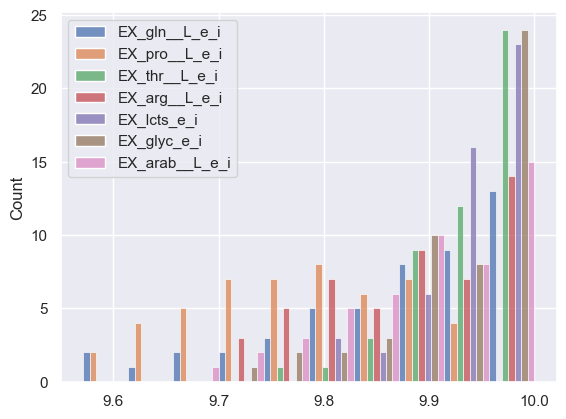

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.close("all")
sns.set_theme()
sns.histplot(s[activated], bins=10, multiple="dodge")
plt.show()